<a href="https://colab.research.google.com/github/Untick/Marketplaces/blob/Domoscanova-Irina-branch/Domoscanova%20Irina/AI_%D1%81%D1%82%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B0_Ingate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Аннотация

Цель работы:

> 1. **Выявить алгоритм**. Найти корреляцию по всем параметрам статистики для
определения работы алгоритмов в категориях. Понять зависимости параметров друг от друга и их последние изменения
2. **Преимущества и точки роста каждой карточки товара на маркетплейсах**. Аудит КТ:
*   уровень заполненности КТ
*   уровень цен
3. **Прогноз продаж любого клиента в категории**. Исходя из статистики общих продаж всех продавцов этой категории спрогнозировать объем продаж гипотетической карточки товара. Вводим руками цену, остаток, ключевые характеристики, расходы на то или иное продвижения в месяц.
4. **Прогноз продаж карточки товара**. Исходя из статистики общих продаж всех продавцов этой категории, статистики этой КТ и аудита КТ спрогнозировать объем продаж в нескольких вариантах:
*   При полностью заполненной КТ с большим количеством символов в описании и
наличии ключевых слов.
*   При соблюдении рыночной цены (или при снижении цены на 20%)
*   При постоянном наличии остатков на складе


[Техническое задание](https://docs.google.com/document/d/1LsLmSLHW7oyEJ0IA_-oLhGmoffkyswSIPy0kn1KPWbY/)

[Датасет](https://drive.google.com/drive/folders/12nTXoU6l9ekIzqPJVdyIXm2GZEHeL5dz?usp=sharing)

# Импорт библиотек

In [48]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# Загрузка и анализ данных

Из имеющегося датасета в первую очередь анализирую данные с маркетплейса Озон.
По смыслу данные разделены на несколько видов:


*   База - перечень всех артикулов с характеристиками и уникальными ID
*   Данные по воронке продаж отдельно органические и с продвижением
*   Данные по затратам на рекламу
*   Данные по атрибутам в карточке товара
*   Отзывы


План анализа данных:


1.   Соединить все данные от маркетплейса Озон в один датафрейм через уникальный FBS OZON SKU ID
2.   Обработать входные данные и привести их к числовым значениям, где возможно
3.   Составить матрицу корреляций для числовых показателей
4.   Сделать выводы о зависимости показателей



## 1. Создание единого датафрейма из данных от маркетплейса Озон

In [49]:
# Загрузка файла с базов артикулов в colab

nomenclature = pd.read_csv('/content/drive/MyDrive/AI/Стажировка Прогнозирование продаж на маркетплейсах INGATE/База.csv', sep=";", header=0)
nomenclature.head()

,Артикул,Ozon Product ID,FBO OZON SKU ID,FBS OZON SKU ID,Barcode,Наименование товара,Контент-рейтинг,Бренд,Статус товара,Видимость FBO,...,"Вывезти и нанести КИЗ (кроме Твери), шт","Зарезервировано, шт","Доступно на моих складах, шт","Зарезервировано на моих складах, шт","Текущая цена с учетом скидки, руб.","Цена до скидки (перечеркнутая цена), руб.","Цена Premium, руб.","Рыночная цена, руб.",Актуальная ссылка на рыночную цену,"Размер НДС, %"
0,'30273,105606938,298131117,298131122,2000000036618,Плата B003809.2 заднего фонаря BMW X3 F25 (дра...,'15,GNX,Продается,Показывается,...,0,0,26,0,1200.0,1800.0,NaN,NaN,NaN,0%
1,'30383,105742204,298264198,298264234,2000000037899,Биксеноновая линза GNX Hella 3R Crystal Vision...,'37.5,GNX,Продается,Показывается,...,0,0,410,0,1990.0,3500.0,NaN,NaN,NaN,0%
2,'31284,112525698,303785665,303785701,NaN,Светодиодные линзы Bi-Led AOZOOM A3 Max 5500K ...,'30,Aozoom,Продается,Показывается,...,0,0,10,0,7900.0,NaN,NaN,NaN,NaN,0%
3,'25775,175507357,409388811,409388809,2000000005034,Герметик для фар жесткий бутиловый черный (4 м...,'17.5,GNX,Продается,Показывается,...,0,0,873,0,1200.0,NaN,NaN,NaN,NaN,0%
4,'29740,175521273,409666236,409666237,2000000030531,Линзы ксенон для фар Ford Focus 2 2007-2011 (C...,'15,GNX,Продается,Показывается,...,0,0,47,0,4500.0,6300.0,NaN,NaN,NaN,0%


In [50]:
# Загрузка файла по органической воронке продаж в colab

orders = pd.read_excel('/content/drive/MyDrive/AI/Стажировка Прогнозирование продаж на маркетплейсах INGATE/Аналитика Графики 01.06.2022-31.05.2023.xlsx', sheet_name= 'Sheet1')
orders.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку"
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-03,1,1,6,1,4,"1,00",0,0,0,0,0,0,0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-05,1,0,2,0,2,"1,00",0,0,0,0,0,0,0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65,3,69,3,40,"110,33",0,0,0,0,0,0,0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85,3,109,3,46,"103,43",0,0,0,0,0,0,0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44,2,50,2,37,"97,14",0,0,0,0,0,0,0


In [51]:
# Загрузка файла по рекламной воронке продаж в colab

promo = pd.read_excel('/content/drive/MyDrive/AI/Стажировка Прогнозирование продаж на маркетплейсах INGATE/Аналитика Акции 01.06.2022-31.05.2023.xlsx', sheet_name= 'Sheet1')
promo.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,Акции,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Доставлено (за выбранный период),Заказано на сумму,Заказано товаров по акции,Заказано на сумму по акции,"Отправления с премиум-подпиской, принятые в обработку"
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,NaN,2023-03-05,65,3,69,3,40,"110,33",0,0,0,0,0,0,0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,NaN,2023-03-06,85,3,109,3,46,"103,43",0,0,0,0,0,0,0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,NaN,2023-03-07,44,2,50,2,37,"97,14",0,0,0,0,0,0,0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,NaN,2023-03-08,47,1,54,2,47,"115,06",0,0,0,0,0,0,0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,NaN,2023-03-09,27,2,39,4,30,"114,37",0,0,0,0,0,0,0


In [52]:
# Создание бэкапов таблиц
backup_nomenclature = nomenclature.copy()
backup_orders = orders.copy()
backup_promo = promo.copy()
display(backup_nomenclature, backup_orders, backup_promo)

,Артикул,Ozon Product ID,FBO OZON SKU ID,FBS OZON SKU ID,Barcode,Наименование товара,Контент-рейтинг,Бренд,Статус товара,Видимость FBO,...,"Вывезти и нанести КИЗ (кроме Твери), шт","Зарезервировано, шт","Доступно на моих складах, шт","Зарезервировано на моих складах, шт","Текущая цена с учетом скидки, руб.","Цена до скидки (перечеркнутая цена), руб.","Цена Premium, руб.","Рыночная цена, руб.",Актуальная ссылка на рыночную цену,"Размер НДС, %"
0,'30273,105606938,298131117,298131122,2000000036618,Плата B003809.2 заднего фонаря BMW X3 F25 (дра...,'15,GNX,Продается,Показывается,...,0,0,26,0,1200.0,1800.0,NaN,NaN,NaN,0%
1,'30383,105742204,298264198,298264234,2000000037899,Биксеноновая линза GNX Hella 3R Crystal Vision...,'37.5,GNX,Продается,Показывается,...,0,0,410,0,1990.0,3500.0,NaN,NaN,NaN,0%
2,'31284,112525698,303785665,303785701,NaN,Светодиодные линзы Bi-Led AOZOOM A3 Max 5500K ...,'30,Aozoom,Продается,Показывается,...,0,0,10,0,7900.0,NaN,NaN,NaN,NaN,0%
3,'25775,175507357,409388811,409388809,2000000005034,Герметик для фар жесткий бутиловый черный (4 м...,'17.5,GNX,Продается,Показывается,...,0,0,873,0,1200.0,NaN,NaN,NaN,NaN,0%
4,'29740,175521273,409666236,409666237,2000000030531,Линзы ксенон для фар Ford Focus 2 2007-2011 (C...,'15,GNX,Продается,Показывается,...,0,0,47,0,4500.0,6300.0,NaN,NaN,NaN,0%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,'30741,82616397,275500050,275500058,2000000038353,Светодиодные линзы Aozoom A7 (комплект),'20,Aozoom,Готов к продаже,Показывается,...,0,0,0,0,10900.0,21000.0,NaN,NaN,NaN,0%
1259,'25380,83513072,276736884,276736895,NaN,Блок розжига CAN-BUS чип ASIC 12V 50W,'25,MTF Light,Готов к продаже,Показывается,...,0,0,0,0,2000.0,NaN,NaN,NaN,NaN,0%
1260,'31062,84952144,278434862,278434864,2000000041698,"Стекло фары, GNX, левое, поликарбонат, для авт...",'15,GNX,Продается,Показывается,...,0,0,4,0,9095.0,16150.0,NaN,NaN,NaN,0%
1261,'29611,85002310,278437400,278437421,2000000029252,"Стекло фары Volkswagen Touareg 2010-2014, лево...",'15,GNX,Продается,Показывается,...,0,0,20,0,10836.0,19608.0,NaN,NaN,NaN,0%


,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку"
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-03,1,1,6,1,4,"1,00",0,0,0,0,0,0,0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-05,1,0,2,0,2,"1,00",0,0,0,0,0,0,0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65,3,69,3,40,"110,33",0,0,0,0,0,0,0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85,3,109,3,46,"103,43",0,0,0,0,0,0,0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44,2,50,2,37,"97,14",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254743,Другое,Линзы Hella 3R Clear для фар Subaru Outback 4 ...,Линзы Hella 3R Clear для фар Subaru Outback 4 ...,579829972,29737,2023-02-05,19,0,35,0,2,"111,50",0,0,0,0,0,0,0
254744,Другое,Линзы Hella 3R Crystal для фар Toyota Camry XV...,Линзы Hella 3R Crystal для фар Toyota Camry XV...,579855355,33889,2023-02-04,1,0,1,0,1,"20,00",0,0,0,0,0,0,0
254745,Другое,Линзы Hella 3R Crystal для фар Toyota Camry XV...,Линзы Hella 3R Crystal для фар Toyota Camry XV...,579855355,33889,2023-02-05,8,0,8,0,3,"94,67",0,0,0,0,0,0,0
254746,Другое,Линзы LED для фар Ford Focus 2 2007-2011 (A3MAX),NaN,747165936,34115,2022-10-14,1,0,1,0,0,"0,00",0,0,0,0,0,0,0


,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,Акции,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Доставлено (за выбранный период),Заказано на сумму,Заказано товаров по акции,Заказано на сумму по акции,"Отправления с премиум-подпиской, принятые в обработку"
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,NaN,2023-03-05,65,3,69,3,40,"110,33",0,0,0,0,0,0,0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,NaN,2023-03-06,85,3,109,3,46,"103,43",0,0,0,0,0,0,0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,NaN,2023-03-07,44,2,50,2,37,"97,14",0,0,0,0,0,0,0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,NaN,2023-03-08,47,1,54,2,47,"115,06",0,0,0,0,0,0,0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,NaN,2023-03-09,27,2,39,4,30,"114,37",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239952,Другое,Переходная рамка Land Rover Discovery 3 2004-2...,Переходная рамка Land Rover Discovery 3 2004-2...,506106738,26264,NaN,2023-02-05,8,1,15,1,2,"124,00",0,0,0,0,0,0,0
239953,Другое,Линзы Hella 3R Clear для фар Subaru Outback 4 ...,Линзы Hella 3R Clear для фар Subaru Outback 4 ...,579829972,29737,NaN,2023-02-05,19,0,35,0,2,"111,50",0,0,0,0,0,0,0
239954,Другое,Линзы Hella 3R Crystal для фар Toyota Camry XV...,Линзы Hella 3R Crystal для фар Toyota Camry XV...,579855355,33889,NaN,2023-02-04,1,0,1,0,1,"20,00",0,0,0,0,0,0,0
239955,Другое,Линзы Hella 3R Crystal для фар Toyota Camry XV...,Линзы Hella 3R Crystal для фар Toyota Camry XV...,579855355,33889,NaN,2023-02-05,8,0,8,0,3,"94,67",0,0,0,0,0,0,0


## 2. Обработка входных данных и приведение их к числовым значениям, где возможно

###Анализ данных

Для начала анализирую количество и типы данных во всех датафреймах

In [53]:
# Анализ данных
nomenclature.info()

orders.info()

promo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263 entries, 0 to 1262
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Артикул                                    1263 non-null   object 
 1   Ozon Product ID                            1263 non-null   int64  
 2   FBO OZON SKU ID                            1263 non-null   int64  
 3   FBS OZON SKU ID                            1263 non-null   int64  
 4   Barcode                                    1205 non-null   object 
 5   Наименование товара                        1263 non-null   object 
 6   Контент-рейтинг                            1263 non-null   object 
 7   Бренд                                      1258 non-null   object 
 8   Статус товара                              1263 non-null   object 
 9   Видимость FBO                              1263 non-null   object 
 10  Причины скрытия FBO (при

#### Работа с базой артикулов

В датафрейме с базой артикулов необходимо убрать символ ' в столбце Артикул, чтобы написание совпадало с остальными датафреймами, и в столбцах Контент-рейтинг, Объем товара, л, Объемный вес, кг, чтобы перевести их в числовой формат

In [54]:
# Перевод данных столбца Позиция в поиске и каталоге в числовой формат
nomenclature['Артикул'] = nomenclature['Артикул'].str.replace('\'','').astype(str)
nomenclature['Объем товара, л'] = nomenclature['Объем товара, л'].str.replace('\'','').astype(float)
nomenclature['Объемный вес, кг'] = nomenclature['Объемный вес, кг'].str.replace('\'','').astype(float)
nomenclature['Контент-рейтинг'] = nomenclature['Контент-рейтинг'].str.replace('\'','').str.replace('Рассчитываем','0').str.replace('Не рассчитываем контент-рейтинг для уценки FBS','0').astype(float)
nomenclature.head()

,Артикул,Ozon Product ID,FBO OZON SKU ID,FBS OZON SKU ID,Barcode,Наименование товара,Контент-рейтинг,Бренд,Статус товара,Видимость FBO,...,"Вывезти и нанести КИЗ (кроме Твери), шт","Зарезервировано, шт","Доступно на моих складах, шт","Зарезервировано на моих складах, шт","Текущая цена с учетом скидки, руб.","Цена до скидки (перечеркнутая цена), руб.","Цена Premium, руб.","Рыночная цена, руб.",Актуальная ссылка на рыночную цену,"Размер НДС, %"
0,30273,105606938,298131117,298131122,2000000036618,Плата B003809.2 заднего фонаря BMW X3 F25 (дра...,15.0,GNX,Продается,Показывается,...,0,0,26,0,1200.0,1800.0,NaN,NaN,NaN,0%
1,30383,105742204,298264198,298264234,2000000037899,Биксеноновая линза GNX Hella 3R Crystal Vision...,37.5,GNX,Продается,Показывается,...,0,0,410,0,1990.0,3500.0,NaN,NaN,NaN,0%
2,31284,112525698,303785665,303785701,NaN,Светодиодные линзы Bi-Led AOZOOM A3 Max 5500K ...,30.0,Aozoom,Продается,Показывается,...,0,0,10,0,7900.0,NaN,NaN,NaN,NaN,0%
3,25775,175507357,409388811,409388809,2000000005034,Герметик для фар жесткий бутиловый черный (4 м...,17.5,GNX,Продается,Показывается,...,0,0,873,0,1200.0,NaN,NaN,NaN,NaN,0%
4,29740,175521273,409666236,409666237,2000000030531,Линзы ксенон для фар Ford Focus 2 2007-2011 (C...,15.0,GNX,Продается,Показывается,...,0,0,47,0,4500.0,6300.0,NaN,NaN,NaN,0%


####Работа с датафреймом Графики (органическая воронка)

In [55]:
# Перевод в датафрейме Графики данных столбца Позиция в поиске и каталоге в числовой формат
orders['Позиция в поиске и каталоге'] = orders['Позиция в поиске и каталоге'].str.replace(',','.').astype(float)
orders.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку"
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-03,1,1,6,1,4,1.00,0,0,0,0,0,0,0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-05,1,0,2,0,2,1.00,0,0,0,0,0,0,0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65,3,69,3,40,110.33,0,0,0,0,0,0,0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85,3,109,3,46,103.43,0,0,0,0,0,0,0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44,2,50,2,37,97.14,0,0,0,0,0,0,0


####Работа с датафреймом Акции (воронка продаж по рекламе)

In [9]:
#promo = backup_promo.copy()

In [56]:
# Перевод в датафрейме Акция данных столбца Позиция в поиске и каталоге в числовой формат
promo['Позиция в поиске и каталоге'] = promo['Позиция в поиске и каталоге'].str.replace(',','.').astype(float)
# Перевод столбца Артикул в текст
promo['Артикул'] = promo['Артикул'].astype(str)
promo.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,Акции,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Доставлено (за выбранный период),Заказано на сумму,Заказано товаров по акции,Заказано на сумму по акции,"Отправления с премиум-подпиской, принятые в обработку"
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,NaN,2023-03-05,65,3,69,3,40,110.33,0,0,0,0,0,0,0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,NaN,2023-03-06,85,3,109,3,46,103.43,0,0,0,0,0,0,0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,NaN,2023-03-07,44,2,50,2,37,97.14,0,0,0,0,0,0,0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,NaN,2023-03-08,47,1,54,2,47,115.06,0,0,0,0,0,0,0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,NaN,2023-03-09,27,2,39,4,30,114.37,0,0,0,0,0,0,0


####Объединение датафреймов

In [57]:
# Перед объединением нужно убедиться, что типы данных в одинаковых столбцах совпадают
orders.info()

promo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254748 entries, 0 to 254747
Data columns (total 19 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Категория 3-го уровня                                  254748 non-null  object 
 1   Товары                                                 254748 non-null  object 
 2   Модель                                                 211411 non-null  object 
 3   Ozon ID                                                254748 non-null  int64  
 4   Артикул                                                254748 non-null  object 
 5   День                                                   254748 non-null  object 
 6   Уникальные посетители, всего                           254748 non-null  int64  
 7   Уникальные посетители с просмотром карточки товара     254748 non-null  int64  
 8   Показы, всего                     

In [58]:
# Произвожу объединение датафреймов Графики и Акции по общим столбцам
ozon_data_prev = pd.merge(orders,
                          promo,
                          on=['Ozon ID',
                              'Категория 3-го уровня',
                              'Товары',
                              'Модель',
                              'Артикул',
                              'День',
                              'Уникальные посетители, всего',
                              'Уникальные посетители с просмотром карточки товара',
                              'Показы, всего',
                              'Показы на карточке товара',
                              'Показы в поиске и каталоге',
                              'Позиция в поиске и каталоге',
                              'В корзину, всего',
                              'Заказано товаров',
                              'Доставлено (за выбранный период)',
                              'Заказано на сумму',
                              'Отправления с премиум-подпиской, принятые в обработку'],
                          how='outer')
ozon_data_prev.head(10)

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,...,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку",Акции,Заказано товаров по акции,Заказано на сумму по акции
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-03,1,1,6,1,...,0,0,0.0,0,0.0,0,0,NaN,NaN,NaN
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353426,34414,2023-03-05,1,0,2,0,...,0,0,0.0,0,0.0,0,0,NaN,NaN,NaN
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65,3,69,3,...,0,0,0.0,0,0.0,0,0,NaN,0.0,0.0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85,3,109,3,...,0,0,0.0,0,0.0,0,0,NaN,0.0,0.0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44,2,50,2,...,0,0,0.0,0,0.0,0,0,NaN,0.0,0.0
5,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-08,47,1,54,2,...,0,0,0.0,0,0.0,0,0,NaN,0.0,0.0
6,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-09,27,2,39,4,...,0,0,0.0,0,0.0,0,0,NaN,0.0,0.0
7,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-10,26,1,29,1,...,0,0,0.0,0,0.0,0,0,NaN,0.0,0.0
8,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-11,38,3,51,4,...,0,0,0.0,0,0.0,0,0,NaN,0.0,0.0
9,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-12,41,1,48,1,...,0,0,0.0,0,0.0,0,0,NaN,0.0,0.0


In [59]:
ozon_data_prev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255094 entries, 0 to 255093
Data columns (total 22 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Категория 3-го уровня                                  255094 non-null  object 
 1   Товары                                                 255094 non-null  object 
 2   Модель                                                 211757 non-null  object 
 3   Ozon ID                                                255094 non-null  int64  
 4   Артикул                                                255094 non-null  object 
 5   День                                                   255094 non-null  object 
 6   Уникальные посетители, всего                           255094 non-null  int64  
 7   Уникальные посетители с просмотром карточки товара     255094 non-null  int64  
 8   Показы, всего                     

В полученный датафрейм нужно добавить столбец Контент-рейтинг из датафрейма База. Остальные столбцы датафрейма База несущественны, поэтому предварительно их удаляю

In [60]:
# Бэкап данных датафрейма База до удаления столбцов
backup_nomenclature_beforedel = nomenclature.copy()

In [61]:
nomenclature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263 entries, 0 to 1262
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Артикул                                    1263 non-null   object 
 1   Ozon Product ID                            1263 non-null   int64  
 2   FBO OZON SKU ID                            1263 non-null   int64  
 3   FBS OZON SKU ID                            1263 non-null   int64  
 4   Barcode                                    1205 non-null   object 
 5   Наименование товара                        1263 non-null   object 
 6   Контент-рейтинг                            1263 non-null   float64
 7   Бренд                                      1258 non-null   object 
 8   Статус товара                              1263 non-null   object 
 9   Видимость FBO                              1263 non-null   object 
 10  Причины скрытия FBO (при

In [16]:
#nomenclature = backup_nomenclature_beforedel.copy()

In [62]:
# Удаление столбцов
nomenclature.drop(
    ['Ozon Product ID',
     'FBO OZON SKU ID',
     'Barcode', 'Наименование товара',
     'Бренд',
     'Статус товара',
     'Видимость FBO',
     'Причины скрытия FBO (при наличии)',
     'Видимость FBS',
     'Причины скрытия FBS (при наличии)',
     'Дата создания',
     'Коммерческая категория',
     'Объем товара, л',
     'Объемный вес, кг',
     'Доступно на складе Ozon, шт',
     'Вывезти и нанести КИЗ (кроме Твери), шт',
     'Зарезервировано, шт',
     'Доступно на моих складах, шт',
     'Зарезервировано на моих складах, шт',
     'Текущая цена с учетом скидки, руб.',
     'Цена до скидки (перечеркнутая цена), руб.',
     'Цена Premium, руб.',
     'Рыночная цена, руб.',
     'Актуальная ссылка на рыночную цену',
     'Размер НДС, %'], axis=1, inplace=True)
nomenclature.head()
nomenclature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263 entries, 0 to 1262
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Артикул          1263 non-null   object 
 1   FBS OZON SKU ID  1263 non-null   int64  
 2   Контент-рейтинг  1263 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 29.7+ KB


In [63]:
# Переименовываю столбец FBS OZON SKU ID для объединения
nomenclature.rename({'FBS OZON SKU ID':'Ozon ID'}, axis='columns', inplace=True)
nomenclature.head()

,Артикул,Ozon ID,Контент-рейтинг
0,30273,298131122,15.0
1,30383,298264234,37.5
2,31284,303785701,30.0
3,25775,409388809,17.5
4,29740,409666237,15.0


In [64]:
# Объединяю датафрейм Графики + Акции с датафреймом База
ozon_data = pd.merge(ozon_data_prev, nomenclature, on=['Артикул', 'Ozon ID'])
ozon_data.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,...,Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку",Акции,Заказано товаров по акции,Заказано на сумму по акции,Контент-рейтинг
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65,3,69,3,...,0,0.0,0,0.0,0,0,NaN,0.0,0.0,45.0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85,3,109,3,...,0,0.0,0,0.0,0,0,NaN,0.0,0.0,45.0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44,2,50,2,...,0,0.0,0,0.0,0,0,NaN,0.0,0.0,45.0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-08,47,1,54,2,...,0,0.0,0,0.0,0,0,NaN,0.0,0.0,45.0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-09,27,2,39,4,...,0,0.0,0,0.0,0,0,NaN,0.0,0.0,45.0


In [65]:
# Бэкап данных до удаления столбцов
ozon_data_backup = ozon_data.copy()
ozon_data_backup.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,...,Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку",Акции,Заказано товаров по акции,Заказано на сумму по акции,Контент-рейтинг
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65,3,69,3,...,0,0.0,0,0.0,0,0,NaN,0.0,0.0,45.0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85,3,109,3,...,0,0.0,0,0.0,0,0,NaN,0.0,0.0,45.0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44,2,50,2,...,0,0.0,0,0.0,0,0,NaN,0.0,0.0,45.0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-08,47,1,54,2,...,0,0.0,0,0.0,0,0,NaN,0.0,0.0,45.0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-09,27,2,39,4,...,0,0.0,0,0.0,0,0,NaN,0.0,0.0,45.0


In [83]:
ozon_data = ozon_data_backup.copy()
ozon_data.head ()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,...,Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку",Акции,Заказано товаров по акции,Заказано на сумму по акции,Контент-рейтинг
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65,3,69,3,...,0,0.0,0,0.0,0,0,NaN,0.0,0.0,45.0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85,3,109,3,...,0,0.0,0,0.0,0,0,NaN,0.0,0.0,45.0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44,2,50,2,...,0,0.0,0,0.0,0,0,NaN,0.0,0.0,45.0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-08,47,1,54,2,...,0,0.0,0,0.0,0,0,NaN,0.0,0.0,45.0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-09,27,2,39,4,...,0,0.0,0,0.0,0,0,NaN,0.0,0.0,45.0


In [84]:
# Создание столбца с вычислением среднего чека
ozon_data['Средний чек'] = ozon_data['Заказано на сумму'] / ozon_data['Заказано товаров']
ozon_data.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,...,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку",Акции,Заказано товаров по акции,Заказано на сумму по акции,Контент-рейтинг,Средний чек
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65,3,69,3,...,0.0,0,0.0,0,0,NaN,0.0,0.0,45.0,NaN
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85,3,109,3,...,0.0,0,0.0,0,0,NaN,0.0,0.0,45.0,NaN
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44,2,50,2,...,0.0,0,0.0,0,0,NaN,0.0,0.0,45.0,NaN
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-08,47,1,54,2,...,0.0,0,0.0,0,0,NaN,0.0,0.0,45.0,NaN
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-09,27,2,39,4,...,0.0,0,0.0,0,0,NaN,0.0,0.0,45.0,NaN


In [85]:
# Замена всех пропусков на 0
ozon_data.fillna(0, inplace=True)
ozon_data.head(20)

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,...,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку",Акции,Заказано товаров по акции,Заказано на сумму по акции,Контент-рейтинг,Средний чек
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65,3,69,3,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85,3,109,3,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44,2,50,2,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-08,47,1,54,2,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-09,27,2,39,4,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0
5,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-10,26,1,29,1,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0
6,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-11,38,3,51,4,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0
7,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-12,41,1,48,1,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0
8,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-13,50,2,60,3,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0
9,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-14,47,4,55,4,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0


In [82]:
# Замена названий акций в столбце Акция на единицу
#ozon_data.loc[ozon_data.Акции != '0', 'Акции'] = 1
#ozon_data.head(20)

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,...,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку",Акции,Заказано товаров по акции,Заказано на сумму по акции,Контент-рейтинг,Средний чек
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65,3,69,3,...,0.0,0,0.0,0,0,1,0.0,0.0,45.0,0.0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85,3,109,3,...,0.0,0,0.0,0,0,1,0.0,0.0,45.0,0.0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44,2,50,2,...,0.0,0,0.0,0,0,1,0.0,0.0,45.0,0.0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-08,47,1,54,2,...,0.0,0,0.0,0,0,1,0.0,0.0,45.0,0.0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-09,27,2,39,4,...,0.0,0,0.0,0,0,1,0.0,0.0,45.0,0.0
5,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-10,26,1,29,1,...,0.0,0,0.0,0,0,1,0.0,0.0,45.0,0.0
6,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-11,38,3,51,4,...,0.0,0,0.0,0,0,1,0.0,0.0,45.0,0.0
7,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-12,41,1,48,1,...,0.0,0,0.0,0,0,1,0.0,0.0,45.0,0.0
8,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-13,50,2,60,3,...,0.0,0,0.0,0,0,1,0.0,0.0,45.0,0.0
9,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-14,47,4,55,4,...,0.0,0,0.0,0,0,1,0.0,0.0,45.0,0.0


###Матрица корреляций

In [86]:
ozon_data.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,...,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку",Акции,Заказано товаров по акции,Заказано на сумму по акции,Контент-рейтинг,Средний чек
0,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65,3,69,3,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0
1,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85,3,109,3,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0
2,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44,2,50,2,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0
3,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-08,47,1,54,2,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0
4,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-09,27,2,39,4,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0


Перевожу дату в тип DataTime

In [87]:
# Перевод даты в индекс
ozon_data.index = pd.to_datetime(ozon_data.День)
ozon_data.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,День,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,...,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку",Акции,Заказано товаров по акции,Заказано на сумму по акции,Контент-рейтинг,Средний чек
День,,,,,,,,,,,,,,,,,,,,,
2023-03-05,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-05,65,3,69,3,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0
2023-03-06,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-06,85,3,109,3,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0
2023-03-07,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-07,44,2,50,2,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0
2023-03-08,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-08,47,1,54,2,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0
2023-03-09,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,2023-03-09,27,2,39,4,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0


In [88]:
# Удаление лишнего столбца с датой
ozon_data.drop('День', axis=1, inplace=True)
ozon_data.head()

,Категория 3-го уровня,Товары,Модель,Ozon ID,Артикул,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,...,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку",Акции,Заказано товаров по акции,Заказано на сумму по акции,Контент-рейтинг,Средний чек
День,,,,,,,,,,,,,,,,,,,,,
2023-03-05,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,65,3,69,3,40,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0
2023-03-06,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,85,3,109,3,46,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0
2023-03-07,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,44,2,50,2,37,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0
2023-03-08,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,47,1,54,2,47,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0
2023-03-09,Разное автопринадлежности,Светодиодная подсветка салона,Светодиодная подсветка салона,882353427,34414,27,2,39,4,30,...,0.0,0,0.0,0,0,0,0.0,0.0,45.0,0.0


Удаляю столбцы с текстовыми данными перед созданием матрицы корреляций



In [89]:
ozon_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 245055 entries, 2023-03-05 to 2023-05-31
Data columns (total 23 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Категория 3-го уровня                                  245055 non-null  object 
 1   Товары                                                 245055 non-null  object 
 2   Модель                                                 245055 non-null  object 
 3   Ozon ID                                                245055 non-null  int64  
 4   Артикул                                                245055 non-null  object 
 5   Уникальные посетители, всего                           245055 non-null  int64  
 6   Уникальные посетители с просмотром карточки товара     245055 non-null  int64  
 7   Показы, всего                                          245055 non-null  int64  
 8   Показы на карточке

In [90]:
# Удаление столбцов Товары и Модель
ozon_data.drop(['Товары', 'Модель', 'Артикул', 'Акции'], axis=1, inplace=True)
ozon_data.head()

,Категория 3-го уровня,Ozon ID,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку",Заказано товаров по акции,Заказано на сумму по акции,Контент-рейтинг,Средний чек
День,,,,,,,,,,,,,,,,,,,
2023-03-05,Разное автопринадлежности,882353427,65,3,69,3,40,110.33,0,0,0.0,0,0.0,0,0,0.0,0.0,45.0,0.0
2023-03-06,Разное автопринадлежности,882353427,85,3,109,3,46,103.43,0,0,0.0,0,0.0,0,0,0.0,0.0,45.0,0.0
2023-03-07,Разное автопринадлежности,882353427,44,2,50,2,37,97.14,0,0,0.0,0,0.0,0,0,0.0,0.0,45.0,0.0
2023-03-08,Разное автопринадлежности,882353427,47,1,54,2,47,115.06,0,0,0.0,0,0.0,0,0,0.0,0.0,45.0,0.0
2023-03-09,Разное автопринадлежности,882353427,27,2,39,4,30,114.37,0,0,0.0,0,0.0,0,0,0.0,0.0,45.0,0.0


In [92]:
# Формирую датафрейм для корреляции только с числовыми данными
ozon_data_corr = ozon_data.drop(['Категория 3-го уровня', 'Ozon ID'], axis=1)
ozon_data_corr.head()

,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку",Заказано товаров по акции,Заказано на сумму по акции,Контент-рейтинг,Средний чек
День,,,,,,,,,,,,,,,,,
2023-03-05,65,3,69,3,40,110.33,0,0,0.0,0,0.0,0,0,0.0,0.0,45.0,0.0
2023-03-06,85,3,109,3,46,103.43,0,0,0.0,0,0.0,0,0,0.0,0.0,45.0,0.0
2023-03-07,44,2,50,2,37,97.14,0,0,0.0,0,0.0,0,0,0.0,0.0,45.0,0.0
2023-03-08,47,1,54,2,47,115.06,0,0,0.0,0,0.0,0,0,0.0,0.0,45.0,0.0
2023-03-09,27,2,39,4,30,114.37,0,0,0.0,0,0.0,0,0,0.0,0.0,45.0,0.0


In [98]:
# Матрица корреляций по критерию Пирсона
ozon_data_corr_matrixP = ozon_data_corr.corr(method='pearson')
ozon_data_corr_matrixP

,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку",Заказано товаров по акции,Заказано на сумму по акции,Контент-рейтинг,Средний чек
"Уникальные посетители, всего",1.000000,0.730332,0.942815,0.636483,0.746856,-0.073831,0.480203,0.317481,0.068087,0.279291,0.028797,0.276010,0.109314,0.230814,0.187471,0.166134,0.206267
Уникальные посетители с просмотром карточки товара,0.730332,1.000000,0.814341,0.964338,0.457336,-0.079687,0.714906,0.432110,0.089444,0.342987,0.037613,0.467800,0.144997,0.224589,0.225862,0.171410,0.319664
"Показы, всего",0.942815,0.814341,1.000000,0.785388,0.701410,-0.074113,0.598886,0.361771,0.079217,0.307725,0.029679,0.372444,0.132985,0.196532,0.163280,0.162559,0.241735
Показы на карточке товара,0.636483,0.964338,0.785388,1.000000,0.402272,-0.073405,0.766982,0.457006,0.095772,0.335540,0.035999,0.526286,0.152556,0.196795,0.204629,0.158880,0.335626
Показы в поиске и каталоге,0.746856,0.457336,0.701410,0.402272,1.000000,-0.059804,0.327418,0.215682,0.046696,0.196956,0.022415,0.192843,0.088012,0.159327,0.151747,0.137460,0.154408
Позиция в поиске и каталоге,-0.073831,-0.079687,-0.074113,-0.073405,-0.059804,1.000000,-0.065875,-0.046325,-0.015369,-0.048523,-0.008919,-0.039959,-0.020345,-0.028054,-0.026581,-0.097912,-0.045078
"В корзину, всего",0.480203,0.714906,0.598886,0.766982,0.327418,-0.065875,1.000000,0.569737,0.116189,0.316088,0.026094,0.610487,0.150916,0.254495,0.241545,0.172840,0.403915
Заказано товаров,0.317481,0.432110,0.361771,0.457006,0.215682,-0.046325,0.569737,1.000000,0.162784,0.238103,0.020644,0.797620,0.112684,0.579925,0.458407,0.121425,0.652671
Отменено товаров,0.068087,0.089444,0.079217,0.095772,0.046696,-0.015369,0.116189,0.162784,1.000000,0.060946,0.002301,0.135589,0.026712,0.082302,0.081071,0.033231,0.110326
Доставлено (за выбранный период),0.279291,0.342987,0.307725,0.335540,0.196956,-0.048523,0.316088,0.238103,0.060946,1.000000,0.073986,0.224756,0.387842,0.139824,0.103719,0.115840,0.151796


Визуализация матрицы корреляций по критерию Пирсона

In [99]:
# Перевожу ozon_data_corr_matrixP в npy массив
np_ozon_data_corr_matrixP = ozon_data_corr_matrixP.values
print(np_ozon_data_corr_matrixP.shape)
print(np_ozon_data_corr_matrixP[0])

(17, 17)
[ 1.          0.73033246  0.94281485  0.63648314  0.74685588 -0.07383133
  0.48020256  0.31748076  0.06808722  0.27929057  0.02879664  0.27600966
  0.10931408  0.23081373  0.18747134  0.16613366  0.20626689]


<function matplotlib.pyplot.show(close=None, block=None)>

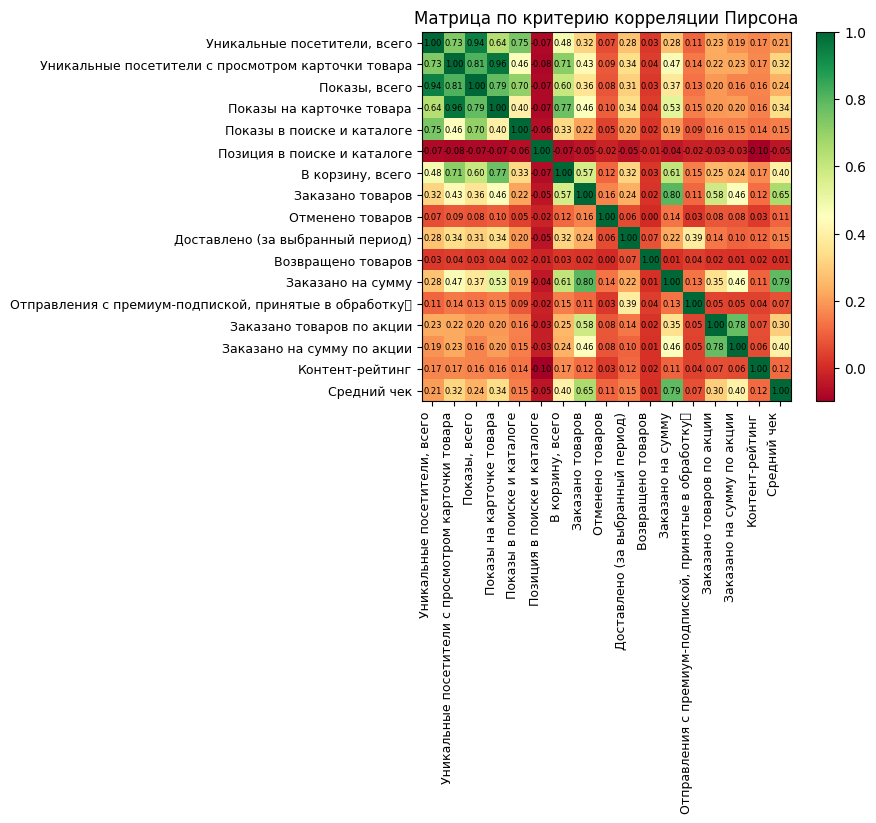

In [106]:
# Строю тепловую карту по критерию корреляции Пирсона

# Лейблы оси X
x = ['Уникальные посетители, всего',
     'Уникальные посетители с просмотром карточки товара',
     'Показы, всего',
     'Показы на карточке товара',
     'Показы в поиске и каталоге',
     'Позиция в поиске и каталоге',
     'В корзину, всего',
     'Заказано товаров',
     'Отменено товаров',
     'Доставлено (за выбранный период)',
     'Возвращено товаров',
     'Заказано на сумму',
     'Отправления с премиум-подпиской, принятые в обработку	',
     'Заказано товаров по акции',
     'Заказано на сумму по акции',
     'Контент-рейтинг',
     'Средний чек']

# Лейблы оси Y
y = ['Уникальные посетители, всего',
     'Уникальные посетители с просмотром карточки товара',
     'Показы, всего',
     'Показы на карточке товара',
     'Показы в поиске и каталоге',
     'Позиция в поиске и каталоге',
     'В корзину, всего',
     'Заказано товаров',
     'Отменено товаров',
     'Доставлено (за выбранный период)',
     'Возвращено товаров',
     'Заказано на сумму',
     'Отправления с премиум-подпиской, принятые в обработку	',
     'Заказано товаров по акции',
     'Заказано на сумму по акции',
     'Контент-рейтинг',
     'Средний чек']

# Построение тепловой карты
fig, ax = plt.subplots()                                                        # Отрисовка рамок и осей
im = plt.imshow(np_ozon_data_corr_matrixP, cmap='RdYlGn')                                  # Отрисовка данных
ax.set_xticks(np.arange(len(x)), labels=x)                                      # Отрисовка делений и подписей к делениям
ax.set_yticks(np.arange(len(y)), labels=y)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", fontsize=9)             # Параметры для подписей делений
plt.setp(ax.get_yticklabels(), fontsize=9)

for i in range(len(y)):
    for j in range(len(x)):
        text = ax.text(j, i, '{0:0.2f}'.format(np_ozon_data_corr_matrixP[i, j]),
                       ha="center", va="center", color="black", fontsize=6)

#
fig.colorbar(im)

# Заголовок графика
plt.title('Матрица по критерию корреляции Пирсона')
plt.show

Для оценки тесноты, или силы, корреляционной связи обычно используют общепринятые критерии, согласно которым абсолютные значения коэффициента корреляции Пирсона rxy < 0.3 свидетельствуют о слабой связи, значения rxy от 0.3 до 0.7 - о связи средней тесноты, значения rxy > 0.7 - о сильной связи.

Более точную оценку силы корреляционной связи можно получить, если воспользоваться таблицей Чеддока:

In [97]:
cheddock = pd.DataFrame([['менее 0.3', 'слабая'],
                         ['от 0.3 до 0.5', 'умеренная'],
                         ['от 0.5 до 0.7', 'заметная'],
                         ['от 0.7 до 0.9', 'высокая'],
                         ['более 0.9', 'весьма высокая']],
                        columns=['Абсолютное значение rxy', 'Теснота (сила) корреляционной связи'])
display(cheddock)

,Абсолютное значение rxy,Теснота (сила) корреляционной связи
0,менее 0.3,слабая
1,от 0.3 до 0.5,умеренная
2,от 0.5 до 0.7,заметная
3,от 0.7 до 0.9,высокая
4,более 0.9,весьма высокая


In [101]:
# Матрица корреляций по коэффициенту ранговой корреляции Спирмена
ozon_data_corr_matrixS = ozon_data_corr.corr(method='spearman')
ozon_data_corr_matrixS

,"Уникальные посетители, всего",Уникальные посетители с просмотром карточки товара,"Показы, всего",Показы на карточке товара,Показы в поиске и каталоге,Позиция в поиске и каталоге,"В корзину, всего",Заказано товаров,Отменено товаров,Доставлено (за выбранный период),Возвращено товаров,Заказано на сумму,"Отправления с премиум-подпиской, принятые в обработку",Заказано товаров по акции,Заказано на сумму по акции,Контент-рейтинг,Средний чек
"Уникальные посетители, всего",1.000000,0.647557,0.981721,0.643766,0.877023,0.158263,0.375215,0.217864,0.047150,0.186437,0.024046,0.217861,0.066890,0.130295,0.130302,0.180017,0.217702
Уникальные посетители с просмотром карточки товара,0.647557,1.000000,0.675427,0.995498,0.586769,-0.075519,0.492088,0.282582,0.060419,0.200399,0.033541,0.282713,0.072769,0.159839,0.159852,0.199966,0.282568
"Показы, всего",0.981721,0.675427,1.000000,0.675101,0.879873,0.136675,0.387029,0.227082,0.049303,0.186374,0.025477,0.227119,0.067032,0.130744,0.130753,0.195313,0.226984
Показы на карточке товара,0.643766,0.995498,0.675101,1.000000,0.583074,-0.074007,0.501782,0.291828,0.061982,0.198967,0.033766,0.291945,0.072518,0.162739,0.162749,0.198398,0.291820
Показы в поиске и каталоге,0.877023,0.586769,0.879873,0.583074,1.000000,0.274692,0.360965,0.208790,0.042321,0.163833,0.019844,0.208834,0.057845,0.122065,0.122078,0.188654,0.208669
Позиция в поиске и каталоге,0.158263,-0.075519,0.136675,-0.074007,0.274692,1.000000,-0.072003,-0.048973,-0.018426,-0.060618,-0.011239,-0.049007,-0.024814,-0.034564,-0.034578,-0.098298,-0.048840
"В корзину, всего",0.375215,0.492088,0.387029,0.501782,0.360965,-0.072003,1.000000,0.461222,0.082641,0.212176,0.022935,0.461283,0.078219,0.257958,0.257954,0.173852,0.460961
Заказано товаров,0.217864,0.282582,0.227082,0.291828,0.208790,-0.048973,0.461222,1.000000,0.135908,0.175116,0.016830,0.999873,0.072514,0.546540,0.546525,0.109324,0.999781
Отменено товаров,0.047150,0.060419,0.049303,0.061982,0.042321,-0.018426,0.082641,0.135908,1.000000,0.045373,0.003513,0.135807,0.027979,0.072891,0.072900,0.027555,0.135283
Доставлено (за выбранный период),0.186437,0.200399,0.186374,0.198967,0.163833,-0.060618,0.212176,0.175116,0.045373,1.000000,0.082574,0.175010,0.351134,0.119528,0.119466,0.103134,0.174495


In [102]:
# Перевожу ozon_data_corr_matrixS в npy массив
np_ozon_data_corr_matrixS = ozon_data_corr_matrixS.values
print(np_ozon_data_corr_matrixS.shape)
print(np_ozon_data_corr_matrixS[0])

(17, 17)
[1.         0.64755688 0.9817206  0.64376577 0.87702313 0.15826276
 0.37521535 0.21786362 0.04715039 0.18643659 0.02404575 0.21786123
 0.06689046 0.1302947  0.13030211 0.1800166  0.21770196]


<function matplotlib.pyplot.show(close=None, block=None)>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


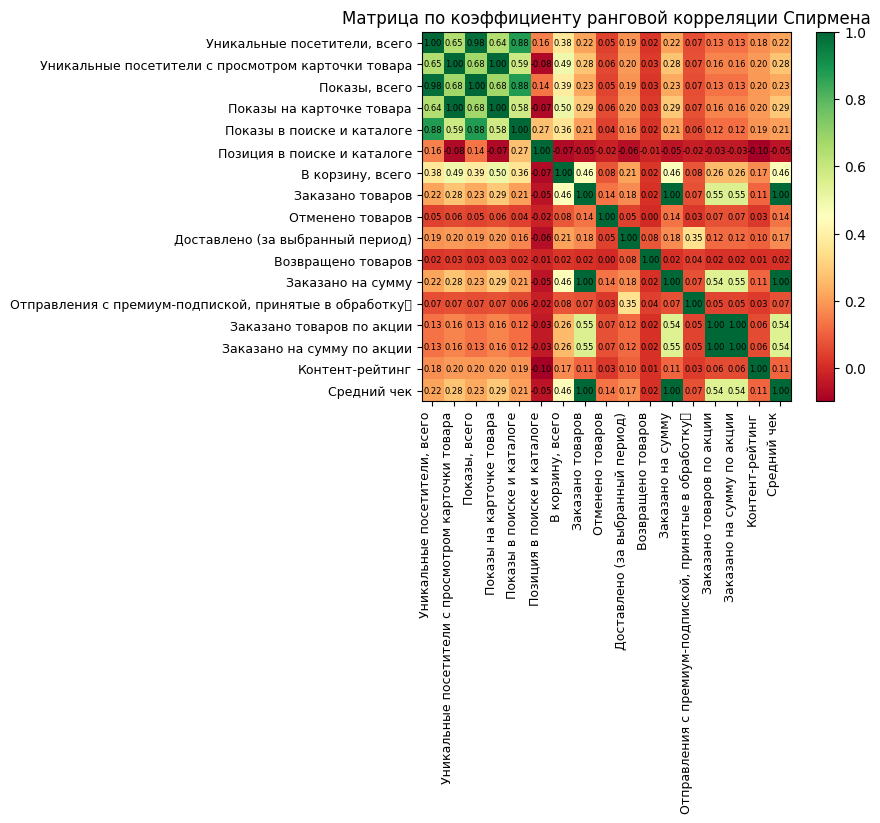

In [105]:
# Строю тепловую карту по коэффициенту ранговой корреляции Спирмена

# Лейблы оси X
x = ['Уникальные посетители, всего',
     'Уникальные посетители с просмотром карточки товара',
     'Показы, всего',
     'Показы на карточке товара',
     'Показы в поиске и каталоге',
     'Позиция в поиске и каталоге',
     'В корзину, всего',
     'Заказано товаров',
     'Отменено товаров',
     'Доставлено (за выбранный период)',
     'Возвращено товаров',
     'Заказано на сумму',
     'Отправления с премиум-подпиской, принятые в обработку	',
     'Заказано товаров по акции',
     'Заказано на сумму по акции',
     'Контент-рейтинг',
     'Средний чек']

# Лейблы оси Y
y = ['Уникальные посетители, всего',
     'Уникальные посетители с просмотром карточки товара',
     'Показы, всего',
     'Показы на карточке товара',
     'Показы в поиске и каталоге',
     'Позиция в поиске и каталоге',
     'В корзину, всего',
     'Заказано товаров',
     'Отменено товаров',
     'Доставлено (за выбранный период)',
     'Возвращено товаров',
     'Заказано на сумму',
     'Отправления с премиум-подпиской, принятые в обработку	',
     'Заказано товаров по акции',
     'Заказано на сумму по акции',
     'Контент-рейтинг',
     'Средний чек']

# Построение тепловой карты
fig, ax = plt.subplots()                                                        # Отрисовка рамок и осей
im = plt.imshow(np_ozon_data_corr_matrixS, cmap='RdYlGn')                       # Отрисовка данных
ax.set_xticks(np.arange(len(x)), labels=x)                                      # Отрисовка делений и подписей к делениям
ax.set_yticks(np.arange(len(y)), labels=y)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", fontsize=9)             # Параметры для подписей делений
plt.setp(ax.get_yticklabels(), fontsize=9)

for i in range(len(y)):
    for j in range(len(x)):
        text = ax.text(j, i, '{0:0.2f}'.format(np_ozon_data_corr_matrixS[i, j]),
                       ha="center", va="center", color="black", fontsize=6)

#
fig.colorbar(im)

# Заголовок графика
plt.title('Матрица по коэффициенту ранговой корреляции Спирмена')
plt.show

Для оценки силы корреляционной связи можно, как и в случае коэффициента корреляции Пирсона, воспользоваться таблицей Чеддока:

In [104]:
display(cheddock)

,Абсолютное значение rxy,Теснота (сила) корреляционной связи
0,менее 0.3,слабая
1,от 0.3 до 0.5,умеренная
2,от 0.5 до 0.7,заметная
3,от 0.7 до 0.9,высокая
4,более 0.9,весьма высокая
